# Final Project -- Jiawen Huang jh4179



# Github repo
https://github.com/Jiawen97/final_project

# Youtube Link



# Dataset

Origin: https://camelyon16.grand-challenge.org/Data/

Converted: https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5

# Goal

Train models using a subset of the training data from CAMELYON 16 and evaluated them on the testing images and generate heatmap.

# Project Summary

To detect cancer in high resolution iamge, my project chooses to distract patch at level 5, 6, and 7 as my input so I can speed up in the process of trainging model. 

The project trains two single-scale models -- InceptionV3 and a simple model trained from scratch by using patches distracted at level 5 image and two multi-scale models based on the models built in single-scale part. It also applies data augmentation to improve the model.

To measure the performance of the best model choosen from the four models, the project uses accuracy, precision, and recall as metrics. In the end, heatmaps of three test slides are generated by the best model.

# Methods and Functions

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files 

# Train Test Split and Validation Setup

In order to distract effective patch better, I choose images with more tissues.

I select 6 images as my training images. They are:

> 075, 078, 081, 084, 091, 096

Similarily, I select 3 images as my testing images. They are:

> 016, 101, 110

Validation split will be set to 0.3 when I train models in case of randomness.

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!ls '/content/gdrive/My Drive/slides'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [5]:
train_no = ['075', '078', '081', '084', '091', '096']
test_no = ['016','101','110']

In [6]:
train_slide = []
train_mask = []
test_slide = []
test_mask = []

for i in train_no:
    img_path = '/content/gdrive/My Drive/slides/tumor_%s.tif' % i
    mask_path = '/content/gdrive/My Drive/slides/tumor_%s_mask.tif' % i
    train_slide.append(open_slide(img_path))
    train_mask.append(open_slide(mask_path))

for i in test_no:
    img_path = '/content/gdrive/My Drive/slides/tumor_%s.tif' % i
    mask_path = '/content/gdrive/My Drive/slides/tumor_%s_mask.tif' % i
    test_slide.append(open_slide(img_path))
    test_mask.append(open_slide(mask_path))

# Distract Patches at level 5, 6 and 7

Patch size: 299*299

Center size: 128*128

Goal: prepare training patches for both single scale models and multi scale models, but I may not use some of them for multi scale models.

Considering the result of training, I want to distract patches with tissues more than 40% of the image and also some negative samples that have issues less than 40% of the image to train the model better.

Considering imbalance of the data, I drop 85% of the negative samples with more issues and 98% of the negative samples with less issues.

Considering RAM, I do not need all the patches from the slide, so I randomly collect only 400 samples for each train slide at each level.


In [7]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def get_percent(slide_image):
    tissue_pixels = find_tissue_pixels(slide_image)
    percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
    return percent_tissue

In [25]:
patch_size = 299
center_size = 128
# we need to find how to get the center from the position of patch
move = int((center_size+1)/2)

X_train_5 = []
X_train_6 = []
X_train_7 = []
Y_train = []
selected_points = []

percent = []
for i in range(6):
    ## width and height exchange in read_slide function
    x_max7 = train_slide[i].level_dimensions[7][1]
    y_max7 = train_slide[i].level_dimensions[7][0]
    xs, ys = np.arange(150,x_max7-150,4), np.arange(150,y_max7-150,4)
    points = []
    for x in xs:
        for y in ys:
            points.append([x,y])
    selected_points_temp = []
    max_ = 0

    ## read whole images
    mask5 = read_slide(train_mask[i], x=0, y=0, level=5, width=train_slide[i].level_dimensions[5][0], height=train_slide[i].level_dimensions[5][1])
    slide5 = read_slide(train_slide[i], x=0, y=0, level=5, width=train_slide[i].level_dimensions[5][0], height=train_slide[i].level_dimensions[5][1])

    slide6 = read_slide(train_slide[i], x=0, y=0, level=6, width=train_slide[i].level_dimensions[6][0], height=train_slide[i].level_dimensions[6][1])
    slide7 = read_slide(train_slide[i], x=0, y=0, level=7, width=train_slide[i].level_dimensions[7][0], height=train_slide[i].level_dimensions[7][1])

    while max_ < 400 and len(points)!=0 :
        point = random.choice(points)
        points.remove(point)
        m = point[0]
        n = point[1]
        # m,n means center point in the center window
        mask_image = mask5[m*4-move:m*4-move+128, n*4-move:n*4-move+128]
        slide_image = slide5[m*4-move:m*4-move+128, n*4-move:n*4-move+128]
        if get_percent(slide_image)>40:
            if np.max(mask_image) == 1:
                Y_train.append(1)
                X_train_5.append(slide5[m*4-150:m*4-150+299,n*4-150:n*4-150+299])
                X_train_6.append(slide6[m*2-150:m*2-150+299,n*2-150:n*2-150+299])
                X_train_7.append(slide7[m-150:m-150+299,n-150:n-150+299])
                max_ += 1
                selected_points_temp.append([m,n])
            elif random.random()<0.85:
                continue
            else:
                Y_train.append(0)
                X_train_5.append(slide5[m*4-150:m*4-150+299,n*4-150:n*4-150+299])
                X_train_6.append(slide6[m*2-150:m*2-150+299,n*2-150:n*2-150+299])
                X_train_7.append(slide7[m-150:m-150+299,n-150:n-150+299])
                max_ += 1
                selected_points_temp.append([m,n])
        else:
            if np.max(mask_image) != 1 and random.random()>0.98:
                Y_train.append(0)
                X_train_5.append(slide5[m*4-150:m*4-150+299,n*4-150:n*4-150+299])
                X_train_6.append(slide6[m*2-150:m*2-150+299,n*2-150:n*2-150+299])
                X_train_7.append(slide7[m-150:m-150+299,n-150:n-150+299])
                max_ += 1
                selected_points_temp.append([m,n])
    selected_points.append(selected_points_temp)

In [26]:
pos_number = sum(Y_train)
neg_number = len(Y_train) - pos_number
print("I have %d positive samples and %d negative samples." % (pos_number, neg_number))

I have 1223 positive samples and 1177 negative samples.


In [27]:
# save point, selected_point here is the center point in the center area
selected_points = np.array(selected_points)
# save as .npy
np.save('selected_points.npy',selected_points)

In [8]:
# load saved points for reuse
selected_points = np.load('./gdrive/My Drive/dl_project/selected_points.npy',allow_pickle=True)
selected_points = selected_points.tolist()

patch_size = 299
center_size = 128
# we need to find how to get the center from the position of patch
move = int((center_size+1)/2)

X_train_5 = []
X_train_6 = []
X_train_7 = []
Y_train = []

percent = []
for i in range(6):
    selected_points_temp = selected_points[i]
    max_ = 0

    ## read whole images
    mask5 = read_slide(train_mask[i], x=0, y=0, level=5, width=train_slide[i].level_dimensions[5][0], height=train_slide[i].level_dimensions[5][1])
    slide5 = read_slide(train_slide[i], x=0, y=0, level=5, width=train_slide[i].level_dimensions[5][0], height=train_slide[i].level_dimensions[5][1])

    slide6 = read_slide(train_slide[i], x=0, y=0, level=6, width=train_slide[i].level_dimensions[6][0], height=train_slide[i].level_dimensions[6][1])
    slide7 = read_slide(train_slide[i], x=0, y=0, level=7, width=train_slide[i].level_dimensions[7][0], height=train_slide[i].level_dimensions[7][1])

    for j in range(len(selected_points_temp)) :
        # point = random.choice(points)
        # points.remove(point)
        m = selected_points_temp[j][0]
        n = selected_points_temp[j][1]
        # m,n means center point in the center window
        mask_image = mask5[m*4-move:m*4-move+128, n*4-move:n*4-move+128]
        # slide_image = slide5[m*4-move:m*4-move+128, n*4-move:n*4-move+128]
        # if get_percent(slide_image)>40:
        if np.max(mask_image) == 1:
            Y_train.append(1)
            X_train_5.append(slide5[m*4-150:m*4-150+299,n*4-150:n*4-150+299])
            X_train_6.append(slide6[m*2-150:m*2-150+299,n*2-150:n*2-150+299])
            X_train_7.append(slide7[m-150:m-150+299,n-150:n-150+299])
            # max_ += 1
            # selected_points_temp.append([m,n])
            # elif random.random()<0.7:
            #     continue
        else:
            Y_train.append(0)
            X_train_5.append(slide5[m*4-150:m*4-150+299,n*4-150:n*4-150+299])
            X_train_6.append(slide6[m*2-150:m*2-150+299,n*2-150:n*2-150+299])
            X_train_7.append(slide7[m-150:m-150+299,n-150:n-150+299])

In [9]:
X_train_5 = np.array(X_train_5)
X_train_6 = np.array(X_train_6)
X_train_7 = np.array(X_train_7)
Y_train = np.array(Y_train) 

# Evaluation Method

I use such metrics to evaluate models on validation dataset when training: 

> loss, AUC, accuracy, precision, recall


For test perfomance, evaluation metrics will include:

> Accuracy, Precision, Recall

Since our dataset is an imbalanced dataset, I not only value accuracy, but also value the balance of precision and recall.

# Single Scale -- Transfer Learning

Model:  Inception V3 

Patches:  Level 5 Patches

## Train Added Layers

In [10]:
x_train, x_val, y_train, y_val = train_test_split(preprocess_input(X_train_5.astype('float32')), Y_train, test_size=0.2, random_state=42, stratify=Y_train, shuffle=True)

In [11]:
base_model = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(patch_size, patch_size, 3))

base_model.summary()
base_model.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
dropout_layer = tf.keras.layers.Dropout(0.5)
flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(128, activation='softmax')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    base_model,
    dropout_layer,
    flatten_layer,
    dense_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 38,580,257
Trainable params: 16,777,473
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
METRICS = [tf.keras.metrics.AUC(name='auc'),
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=1)

In [14]:
history1 = model.fit(x_train, y_train, batch_size = 32, epochs= 20, verbose=1, validation_data=(x_val,y_val), shuffle=True, callbacks= [early_stopping])

Epoch 1/20
60/60 [==============================] - 23s 187ms/step - loss: 0.6674 - auc: 0.7763 - accuracy: 0.6990 - precision: 0.7032 - recall: 0.7254 - val_loss: 0.6301 - val_auc: 0.9448 - val_accuracy: 0.8771 - val_precision: 0.8661 - val_recall: 0.8980
Epoch 2/20
60/60 [==============================] - 10s 161ms/step - loss: 0.6234 - auc: 0.9636 - accuracy: 0.9309 - precision: 0.9297 - recall: 0.9349 - val_loss: 0.6156 - val_auc: 0.9795 - val_accuracy: 0.9438 - val_precision: 0.9160 - val_recall: 0.9796
Epoch 3/20
60/60 [==============================] - 10s 162ms/step - loss: 0.6106 - auc: 0.9905 - accuracy: 0.9634 - precision: 0.9511 - recall: 0.9769 - val_loss: 0.6099 - val_auc: 0.9871 - val_accuracy: 0.9542 - val_precision: 0.9478 - val_recall: 0.9633
Epoch 4/20
60/60 [==============================] - 10s 163ms/step - loss: 0.6056 - auc: 0.9934 - accuracy: 0.9770 - precision: 0.9702 - recall: 0.9848 - val_loss: 0.6079 - val_auc: 0.9833 - val_accuracy: 0.9479 - val_precision: 

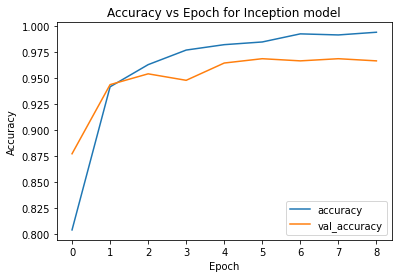

In [15]:
pd.DataFrame(history1.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [16]:
model.save('model1.h5')

# files.download('model1.h5')

## Train Last 30 Layers at the Bottom

In [17]:
model2 = model

for layer in model2.layers[-30:]:
    layer.trainable = True
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 38,580,257
Trainable params: 38,545,825
Non-trainable params: 34,432
_________________________________________________________________


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

history2 = model2.fit(x_train, y_train, batch_size=32, validation_data=(x_val,y_val), epochs = 20, verbose=1, callbacks=[early_stopping],shuffle= True)

Epoch 1/20
60/60 [==============================] - 42s 504ms/step - loss: 0.6346 - auc: 0.9601 - accuracy: 0.8216 - precision: 0.9127 - recall: 0.8750 - val_loss: 0.6101 - val_auc: 0.9733 - val_accuracy: 0.9354 - val_precision: 0.9421 - val_recall: 0.9306
Epoch 2/20
60/60 [==============================] - 29s 484ms/step - loss: 0.5979 - auc: 0.9970 - accuracy: 0.9843 - precision: 0.9801 - recall: 0.9884 - val_loss: 0.6054 - val_auc: 0.9822 - val_accuracy: 0.9375 - val_precision: 0.9317 - val_recall: 0.9469
Epoch 3/20
60/60 [==============================] - 29s 478ms/step - loss: 0.5936 - auc: 0.9984 - accuracy: 0.9918 - precision: 0.9872 - recall: 0.9969 - val_loss: 0.5997 - val_auc: 0.9869 - val_accuracy: 0.9604 - val_precision: 0.9280 - val_recall: 1.0000
Epoch 4/20
60/60 [==============================] - 29s 477ms/step - loss: 0.5926 - auc: 0.9950 - accuracy: 0.9939 - precision: 0.9912 - recall: 0.9971 - val_loss: 0.5974 - val_auc: 0.9901 - val_accuracy: 0.9646 - val_precision: 

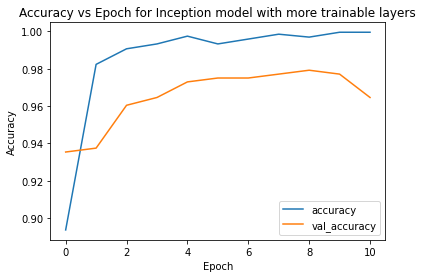

In [19]:
pd.DataFrame(history2.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Inception model with more trainable layers")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [20]:
model2.save('model2.h5')

# files.download('model2.h5')

We see that when we train more parameters, model performance is quite similar to the model when  we only train the last layer. 

## Data Augmentation

Problem: 

> Although all the metrics seems good, when I apply the model listed before into test slide, it appears to classify all the patches as one class, so I asume the model has memorized training data and there may be much more similarities between validation dataset and training dataset than what I expect.

I try to use data augmentation to increase the training dataset size and fix the problem.

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X_train_5.astype('float32'), Y_train, test_size=0.2, random_state=42, stratify=Y_train, shuffle=True)
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0],preprocessing_function=preprocess_input)
it = datagen.flow(x_train, y_train, batch_size=32)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = datagen.flow(x_val,y_val,batch_size=1)

In [11]:
model3 = models.load_model('model2.h5')
# model3 = model2

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)

METRICS = [tf.keras.metrics.AUC(name='auc'),
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

history3 = model3.fit_generator(
      it,
      steps_per_epoch=15,
      epochs=20,
      validation_data = validation_generator,
      callbacks=[early_stopping], verbose=1,shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 46s 2s/step - loss: 0.6171 - auc: 0.9141 - accuracy: 0.8724 - precision: 0.8805 - recall: 0.8744 - val_loss: 0.6282 - val_auc: 0.8983 - val_accuracy: 0.8188 - val_precision: 0.8911 - val_recall: 0.7347
Epoch 2/20
15/15 [==============================] - 25s 2s/step - loss: 0.6075 - auc: 0.9455 - accuracy: 0.9086 - precision: 0.9282 - recall: 0.8856 - val_loss: 0.6170 - val_auc: 0.9279 - val_accuracy: 0.8729 - val_precision: 0.9107 - val_recall: 0.8327
Epoch 3/20
15/15 [==============================] - 25s 2s/step - loss: 0.6056 - auc: 0.9529 - accuracy: 0.9102 - precision: 0.9243 - recall: 0.8988 - val_loss: 0.6139 - val_auc: 0.9387 - val_accuracy: 0.8854 - val_precision: 0.8862 - val_recall: 0.8898
Epoch 4/20
15/15 [==============================] - 25s 2s/step - loss: 0.6048 - auc: 0.9627 - accuracy: 0.9154 - precision: 0.8949 - recall: 0.9456 - val_loss: 0.6135 - val_auc: 0.9302 - val_accuracy: 0.8771 - val_precision: 0.9043 - val

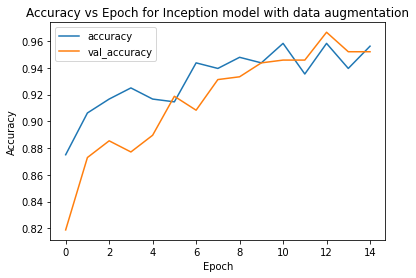

In [12]:
pd.DataFrame(history3.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Inception model with data augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [13]:
model3.save('model3.h5')

# files.download('model3.h5')

Validation accuracy did not improve, but still perform really well.

I will use it for the following models.

# Single Scale -- Simple Model

Patches: Level 5 Patches

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X_train_5.astype('float32'), Y_train, test_size=0.2, random_state=42, stratify=Y_train, shuffle=True)
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0])
it = datagen.flow(x_train, y_train, batch_size=32)

validation_datagen = ImageDataGenerator()
validation_generator = datagen.flow(x_val,y_val,batch_size=1)

In [11]:
patch_size = 299

my_model = models.Sequential()
my_model.add(layers.AveragePooling2D())
my_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(patch_size, patch_size, 3)))
my_model.add(layers.BatchNormalization())
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(patch_size, patch_size, 3)))
my_model.add(layers.BatchNormalization())
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Flatten())
my_model.add(layers.Dense(128, activation='softmax'))
my_model.add(layers.Dense(1, activation='sigmoid'))

METRICS = [tf.keras.metrics.AUC(name='auc'),
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
my_model.compile(opt,
              loss='binary_crossentropy',
              metrics=METRICS)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)

history4 = my_model.fit_generator(
      it,
      steps_per_epoch=15,
      epochs=20,
      validation_data = validation_generator,
      callbacks=[early_stopping], verbose=1,shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 22s 1s/step - loss: 0.6863 - auc: 0.6329 - accuracy: 0.6306 - precision: 0.6063 - recall: 0.7051 - val_loss: 0.6914 - val_auc: 0.5982 - val_accuracy: 0.5208 - val_precision: 0.8571 - val_recall: 0.0735
Epoch 2/20
15/15 [==============================] - 21s 1s/step - loss: 0.6707 - auc: 0.7272 - accuracy: 0.7040 - precision: 0.7572 - recall: 0.6465 - val_loss: 0.6727 - val_auc: 0.7021 - val_accuracy: 0.6583 - val_precision: 0.8716 - val_recall: 0.3878
Epoch 3/20
15/15 [==============================] - 21s 1s/step - loss: 0.6665 - auc: 0.7410 - accuracy: 0.7035 - precision: 0.7108 - recall: 0.6805 - val_loss: 0.6674 - val_auc: 0.7250 - val_accuracy: 0.6938 - val_precision: 0.8101 - val_recall: 0.5224
Epoch 4/20
15/15 [==============================] - 21s 1s/step - loss: 0.6573 - auc: 0.7961 - accuracy: 0.7248 - precision: 0.7241 - recall: 0.7007 - val_loss: 0.6651 - val_auc: 0.7424 - val_accuracy: 0.6979 - val_precision: 0.8049 - val

In [13]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    1

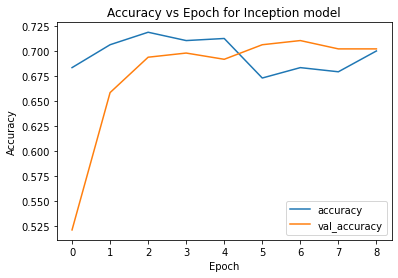

In [14]:
pd.DataFrame(history4.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [15]:
my_model.save('simple_model.h5')

# files.download('simple_model.h5')

We can see the simple model cannot beat InceptionV3.

# Multi Scale -- InceptionV3

Patches: Level 5,6,7 Patches

Considering the RAM constraints of Colab, I only use 40% of the data and only train last 10 layers.

In [10]:
lens = int(len(Y_train)/10*4)
idx = np.arange(lens)
x_train5 = X_train_5[:lens].astype('float32')
x_train6 = X_train_6[:lens].astype('float32') 
x_train7 = X_train_7[:lens].astype('float32') 
y_train7 = Y_train[:lens]

idx_train, idx_test, y_train, y_test = train_test_split(idx, y_train7, test_size=0.2, random_state=42, stratify=y_train7, shuffle=True)

x_train5_train = []
x_train5_test = []
x_train6_train = []
x_train6_test = []
x_train7_train = []
x_train7_test = []

x_train5_train.append(x_train5[idx_train])
x_train6_train.append(x_train6[idx_train])
x_train7_train.append(x_train7[idx_train])

x_train5_test.append(x_train5[idx_test])
x_train6_test.append(x_train6[idx_test])
x_train7_test.append(x_train7[idx_test])

x_train5_train = np.array(x_train5_train).reshape(768,299,299,3)
x_train5_test = (np.array(x_train5_test)).reshape(192,299,299,3)
x_train6_train = (np.array(x_train6_train)).reshape(768,299,299,3)
x_train6_test = (np.array(x_train6_test)).reshape(192,299,299,3)
x_train7_train = (np.array(x_train7_train)).reshape(768,299,299,3)
x_train7_test = (np.array(x_train7_test)).reshape(192,299,299,3)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], preprocessing_function=preprocess_input)

def gen_flow_for_three_inputs(X1, X2, X3, y, batch_size):
    genX1 = datagen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = datagen.flow(X1,X2, batch_size=batch_size,seed=666)
    genX3 = datagen.flow(X1,X3, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i[0], X2i[1], X3i[1]], X1i[1]

it = gen_flow_for_three_inputs(x_train5_train, x_train6_train, x_train7_train, y_train, 8)

In [12]:
patch_size = 299

inception1 = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(patch_size, patch_size, 3))

input1 = inception1.input
output1 = inception1.output
for layer in inception1.layers[:-10]:
    layer.trainable = False
for layer in inception1.layers[-10:]:
    layer.trainable = True

inception2 = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(patch_size, patch_size, 3))
input2 = inception2.input
output2 = inception2.output
for layer in inception2.layers:
    layer._name = layer._name + str("_2")
for layer in inception2.layers[:-10]:
    layer.trainable = False
for layer in inception2.layers[-10:]:
    layer.trainable = True

inception3 = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(patch_size, patch_size, 3))

input3 = inception3.input
output3 = inception3.output
for layer in inception3.layers:
    layer._name = layer._name + str("_3")
for layer in inception3.layers[:-10]:
    layer.trainable = False
for layer in inception3.layers[-10:]:
    layer.trainable = True

merge = layers.concatenate([output1, output2, output3])

flat = layers.Flatten()(merge)
drop1 = layers.Dropout(0.5)(flat)
dense1 = layers.Dense(128, activation='softmax')(drop1)
output = layers.Dense(1, activation='sigmoid')(dense1)

# call model
multi_inceptionV3_model = tf.keras.Model([input1, input2, input3], [output])

plot_model(multi_inceptionV3_model, 'Multi_inception_model.png')

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=1)

METRICS = [tf.keras.metrics.AUC(name='auc'),
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]


opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)
multi_inceptionV3_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

history5 = multi_inceptionV3_model.fit(
      it,
      steps_per_epoch=15,
      epochs=20,
      validation_data = ([x_train5_test,x_train6_test,x_train7_test],[y_test]),
      callbacks=[early_stopping],verbose=1, shuffle=True)

Epoch 1/20
15/15 [==============================] - 35s 1s/step - loss: 0.6748 - auc: 0.5214 - accuracy: 0.6156 - precision: 0.6807 - recall: 0.7883 - val_loss: 0.6675 - val_auc: 0.5000 - val_accuracy: 0.6615 - val_precision: 0.6615 - val_recall: 1.0000
Epoch 2/20
15/15 [==============================] - 10s 691ms/step - loss: 0.6782 - auc: 0.5000 - accuracy: 0.6037 - precision: 0.6037 - recall: 1.0000 - val_loss: 0.6675 - val_auc: 0.5000 - val_accuracy: 0.6615 - val_precision: 0.6615 - val_recall: 1.0000
Epoch 3/20
15/15 [==============================] - 10s 692ms/step - loss: 0.6544 - auc: 0.5729 - accuracy: 0.7309 - precision: 0.7323 - recall: 0.9785 - val_loss: 0.6674 - val_auc: 0.5000 - val_accuracy: 0.6615 - val_precision: 0.6615 - val_recall: 1.0000
Epoch 4/20
15/15 [==============================] - 10s 692ms/step - loss: 0.6721 - auc: 0.6409 - accuracy: 0.5900 - precision: 0.8149 - recall: 0.5565 - val_loss: 0.7048 - val_auc: 0.5236 - val_accuracy: 0.3542 - val_precision: 1.0

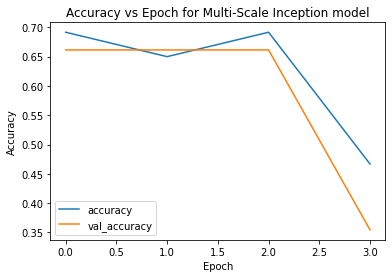

In [14]:
pd.DataFrame(history5.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Multi-Scale Inception model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Multi Scale InceptionV3 model does not improve single scale Inception V3 model, otherwise, it makes the model stop learning from different classes of the images.

# Multi Scale -- Simple Model

Patches: Level 5,6,7 Patches

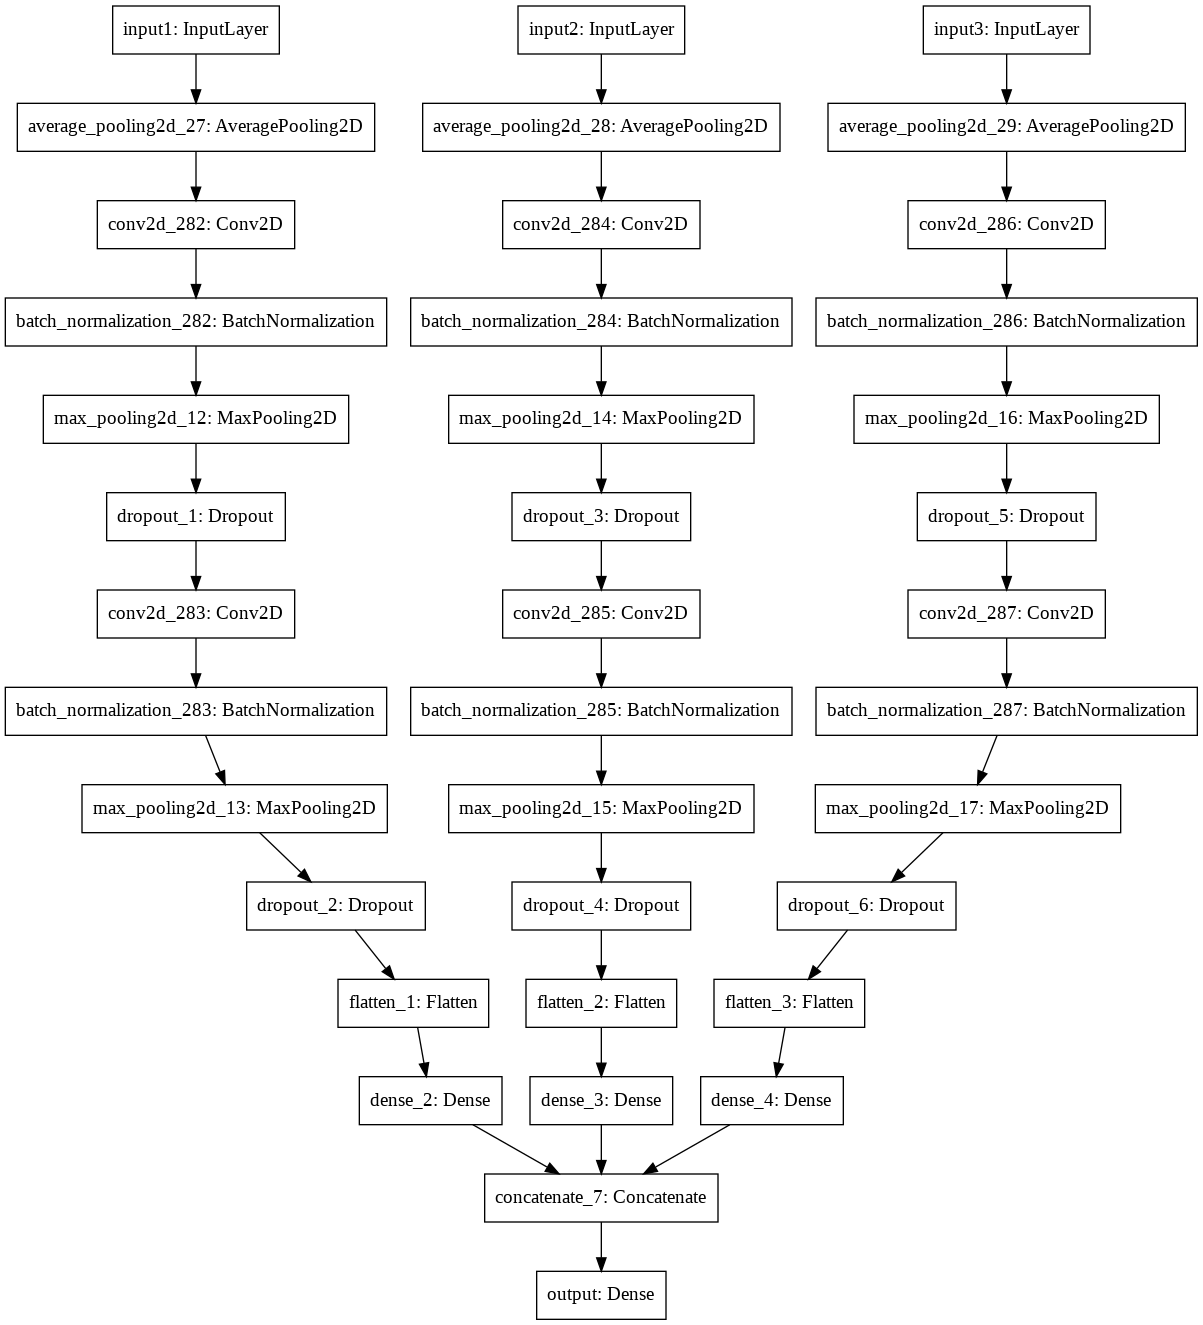

In [15]:
patch_size = 299

def multi_scale_model():
    input1 = Input(shape=(patch_size, patch_size, 3),name='input1')
    input2 = Input(shape=(patch_size, patch_size, 3),name='input2')
    input3 = Input(shape=(patch_size, patch_size, 3),name='input3')

    x1 = layers.AveragePooling2D()(input1)
    x1 = layers.Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(128, activation='softmax')(x1)

    x2 = layers.AveragePooling2D()(input2)
    x2 = layers.Conv2D(32, (3, 3), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D()(x2)
    x2 = layers.Dropout(0.5)(x2)
    x2 = layers.Conv2D(32, (3, 3), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D()(x2)
    x2 = layers.Dropout(0.5)(x2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(128, activation='softmax')(x2)

    x3 = layers.AveragePooling2D()(input3)
    x3 = layers.Conv2D(32, (3, 3), activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.MaxPooling2D()(x3)
    x3 = layers.Dropout(0.5)(x3)
    x3 = layers.Conv2D(32, (3, 3), activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.MaxPooling2D()(x3)
    x3 = layers.Dropout(0.5)(x3)
    x3 = layers.Flatten()(x3)
    x3 = layers.Dense(128, activation='softmax')(x3)

    x = layers.concatenate([x1, x2, x3])
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = tf.keras.Model(inputs=[input1, input2, input3], outputs=[output])

    return model
 

multi_my_model = multi_scale_model()
  
plot_model(multi_my_model, 'Multi_my_model.png')

In [16]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00002)

METRICS = [tf.keras.metrics.AUC(name='auc'),
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

multi_my_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, verbose=1)

history6 = multi_my_model.fit_generator(
      it,
      steps_per_epoch=15,
      epochs=20,
      validation_data = ([x_train5_test,x_train6_test,x_train7_test],y_test),
      #callbacks=[early_stopping], 
      verbose=1,shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 10s 579ms/step - loss: 0.6850 - auc: 0.5951 - accuracy: 0.5392 - precision: 0.5665 - recall: 0.6806 - val_loss: 0.6933 - val_auc: 0.7340 - val_accuracy: 0.4167 - val_precision: 0.8947 - val_recall: 0.1339
Epoch 2/20
15/15 [==============================] - 7s 531ms/step - loss: 0.6627 - auc: 0.6633 - accuracy: 0.7261 - precision: 0.7173 - recall: 0.9431 - val_loss: 0.6725 - val_auc: 0.8007 - val_accuracy: 0.7865 - val_precision: 0.8258 - val_recall: 0.8583
Epoch 3/20
15/15 [==============================] - 8s 525ms/step - loss: 0.6502 - auc: 0.7777 - accuracy: 0.7502 - precision: 0.7228 - recall: 0.9932 - val_loss: 0.6634 - val_auc: 0.7535 - val_accuracy: 0.7344 - val_precision: 0.7262 - val_recall: 0.9606
Epoch 4/20
15/15 [==============================] - 7s 517ms/step - loss: 0.6246 - auc: 0.9018 - accuracy: 0.8246 - precision: 0.7820 - recall: 0.9976 - val_loss: 0.6710 - val_auc: 0.8563 - val_accuracy: 0.7083 - val_precision: 0.9

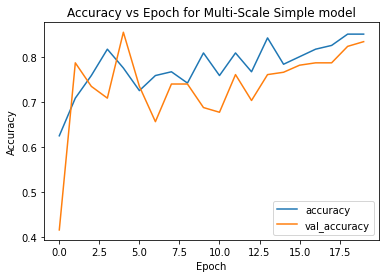

In [17]:
pd.DataFrame(history6.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Multi-Scale Simple model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

It seems like this model can benefit more from longer learning process, so I train it with 20 more epochs.

In [20]:
history7 = multi_my_model.fit_generator(
      it,
      steps_per_epoch=15,
      epochs=20,
      validation_data = ([x_train5_test,x_train6_test,x_train7_test],y_test),
      callbacks=[early_stopping], 
      verbose=1,shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 7s 531ms/step - loss: 0.5778 - auc: 0.9569 - accuracy: 0.8667 - precision: 0.8404 - recall: 0.9875 - val_loss: 0.6109 - val_auc: 0.9675 - val_accuracy: 0.8750 - val_precision: 0.8411 - val_recall: 1.0000
Epoch 2/20
15/15 [==============================] - 8s 524ms/step - loss: 0.5684 - auc: 0.9730 - accuracy: 0.8917 - precision: 0.8812 - recall: 0.9889 - val_loss: 0.6090 - val_auc: 0.9671 - val_accuracy: 0.8750 - val_precision: 0.8411 - val_recall: 1.0000
Epoch 3/20
15/15 [==============================] - 8s 524ms/step - loss: 0.5896 - auc: 0.9262 - accuracy: 0.8500 - precision: 0.8132 - recall: 0.9867 - val_loss: 0.6141 - val_auc: 0.9605 - val_accuracy: 0.8750 - val_precision: 0.8411 - val_recall: 1.0000
Epoch 4/20
15/15 [==============================] - 8s 526ms/step - loss: 0.5818 - auc: 0.9670 - accuracy: 0.8583 - precision: 0.8172 - recall: 1.0000 - val_loss: 0.6214 - val_auc: 0.9551 - val_accuracy: 0.9271 - val_precision: 0.91

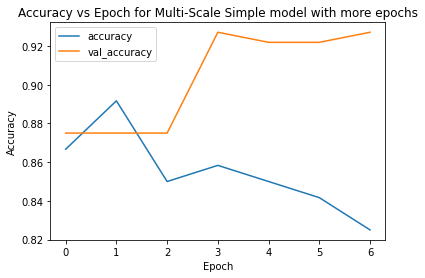

In [21]:
pd.DataFrame(history7.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Multi-Scale Simple model with more epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [22]:
multi_my_model.save('multi_simple_model.h5')

# files.download('multi_simple_model.h5')

Multi-scale simple model improves compared to single-scale simgle model.

# Result and Conclusion

## Generate heatmap and Evaluate

Here I set threshold to 0.5. If you weight false positive error more, you can set it larger than 0.5.



In [8]:
class evaluate:
    def __init__(self, slide, mask, model, threshold, multi=False):
        self.slide = slide
        self.mask = mask
        self.model = model
        self.threshold = threshold
        self.multi = multi

    def image(self):
        slide = self.slide
        mask = self.mask
        self.m_max5 = slide.level_dimensions[5][1]
        self.n_max5 = slide.level_dimensions[5][0]
        self.m_max6 = slide.level_dimensions[6][1]
        self.n_max6 = slide.level_dimensions[6][0]
        self.m_max7 = slide.level_dimensions[7][1]
        self.n_max7 = slide.level_dimensions[7][0]
        self.mask5 = read_slide(mask, x=0, y=0, level=5, width=mask.level_dimensions[5][0], height=mask.level_dimensions[5][1])
        self.slide5 = read_slide(slide, x=0, y=0, level=5, width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])
        self.slide6 = read_slide(slide, x=0, y=0, level=6, width=slide.level_dimensions[6][0], height=slide.level_dimensions[6][1])
        self.slide7 = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
        self.pred = np.zeros((mask.level_dimensions[5][1], mask.level_dimensions[5][0]))
        mask_image = read_slide(mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])
        self.mask_image = mask_image[:,:,0]
        slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])
        self.slide_image = slide_image


    def predict(self):
        TP = 0
        TN = 0
        FP = 0 
        FN = 0
        patch_size = 299
        center_size = 128
        move = int((center_size+1)/2)
        self.image()
        pred = self.pred.copy()
        points = []
        if self.multi==False:
            for m in range(150,self.m_max5-150,128):
               for n in range(150,self.n_max5-150,128):
                   points.append([m,n])
            print("Total patches used to test:",len(points))
            for [m,n] in points:
                input1=self.slide5[m-150:m-150+299, n-150:n-150+299]
                if get_percent(input1)>40:
                    pred_ = self.model.predict(tf.expand_dims(input1,0))
                    mask_image = self.mask5[m-move:m-move+128, n-move:n-move+128]
                    # print(np.max(mask_image)==1, pred_)
                    if pred_[0][0]>self.threshold:
                        pred[m-move:m-move+128, n-move:n-move+128] = 1
                        if np.max(mask_image)==1: 
                            TP += 1
                        else:
                            FP += 1
                    if pred_[0][0]<self.threshold:
                        pred[m-move:m-move+128, n-move:n-move+128] = 0
                        if np.max(mask_image)==1: 
                            FN += 1
                        else:
                            TN += 1
                else:
                    continue
        else: 
            for m in range(150,self.m_max7-150,32):
                for n in range(150,self.n_max7-150,32):
                   points.append([m,n])
            print("Total patches used to test:",len(points))
            for [m,n] in points:
                input1=self.slide5[m*4-150:m*4-150+299, n*4-150:n*4-150+299]
                input2=self.slide6[m*2-150:m*2-150+299, n*2-150:n*2-150+299]
                input3=self.slide7[m-150:m-150+299, n-150:n-150+299]
                if get_percent(input1)>40:
                    pred_ = self.model.predict([tf.expand_dims(input1,0),tf.expand_dims(input2,0),tf.expand_dims(input3,0)])
                    mask_image = self.mask5[m*4-move:m*4-move+128, n*4-move:n*4-move+128]
                    # print(np.max(mask_image)==1, pred_)
                    if pred_[0][0]>self.threshold:
                        pred[m*4-move:m*4-move+128, n*4-move:n*4-move+128] = 1
                        if np.max(mask_image)==1: 
                            TP += 1
                        else:
                            FP += 1
                    if pred_[0][0]<self.threshold:
                        pred[m*4-move*4:m-move+128, n*4-move:n*4-move+128] = 0
                        if np.max(mask_image)==1: 
                            FN += 1
                        else:
                            TN += 1
                else:
                    continue
        self.pred = pred
        plt.figure(figsize=(18,10))
        plt.subplot(1,3,1)
        plt.imshow(self.slide_image)
        plt.imshow(self.mask_image,cmap='jet', alpha=0.5)
        plt.grid(False)
        plt.subplot(1,3,2)
        plt.imshow(self.slide_image)
        plt.imshow(self.pred, cmap='jet',alpha=0.5) 
        plt.grid(False)
        plt.subplot(1,3,3)
        plt.imshow(self.mask_image)
        plt.imshow(self.pred, cmap='jet',alpha=0.5) 
        plt.grid(False)
        plt.show()
        print(TP, TN, FP, FN)
        self.accuracy = (TP+TN)/(TP+TN+FP+FN)
        self.precision = TP/(TP+FP)
        self.recall = TP/(TP+FN)
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)

## Best Model -- Test on Three Slides

From the plots before, we can conclude the best model will be either single-scale InceptionV3 model or multi-scale simple model. I will compare them in this part on three test slides.

### Single-Scale Inception V3 model

Total patches used to test: 1144


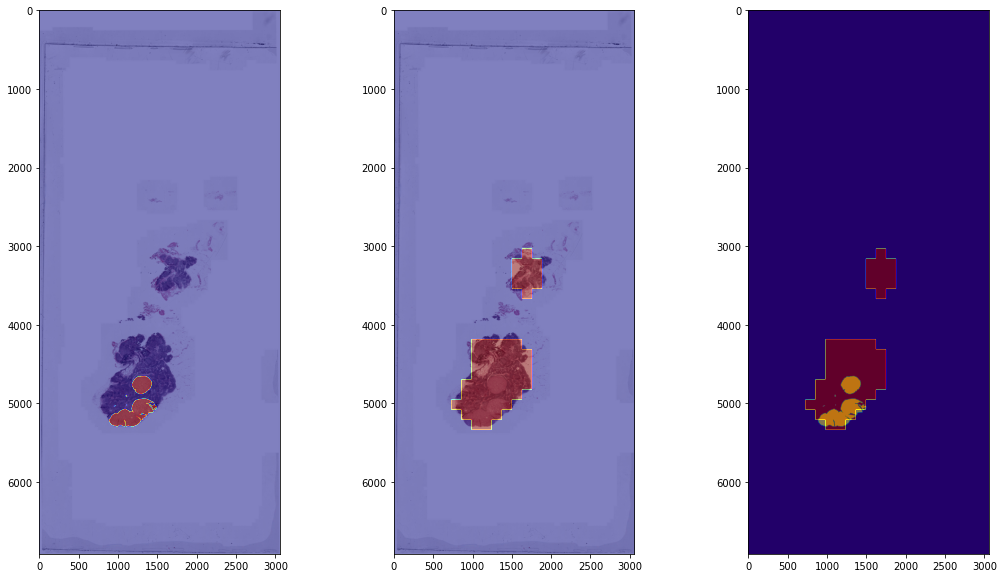

21 0 38 0
Accuracy: 0.3559322033898305
Precision: 0.3559322033898305
Recall: 1.0


In [15]:
single_inceptionv3_model = models.load_model('model3.h5')
test1 = evaluate(test_slide[0], test_mask[0], single_inceptionv3_model, 0.5, multi=False)
test1.predict()

Total patches used to test: 512


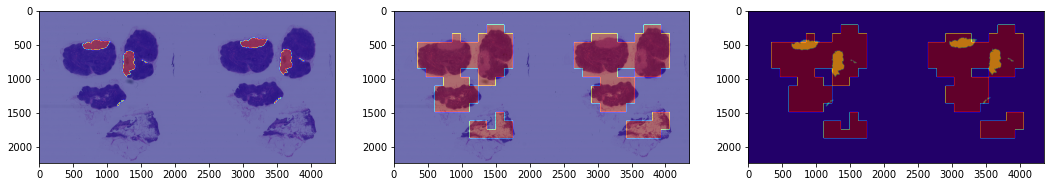

34 0 119 0
Accuracy: 0.2222222222222222
Precision: 0.2222222222222222
Recall: 1.0


In [16]:
test2 = evaluate(test_slide[1], test_mask[1], single_inceptionv3_model, 0.5, multi=False)
test2.predict()

Total patches used to test: 336


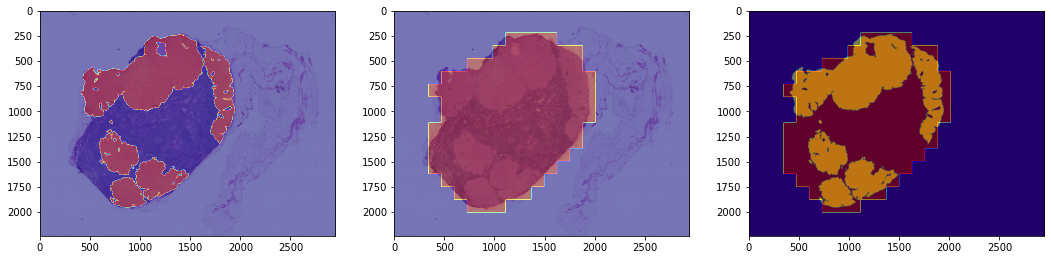

102 0 29 0
Accuracy: 0.7786259541984732
Precision: 0.7786259541984732
Recall: 1.0


In [17]:
test2 = evaluate(test_slide[2], test_mask[2], single_inceptionv3_model, 0.5, multi=False)
test2.predict()

### Multi-Scale Simple Model

Total patches used to test: 675


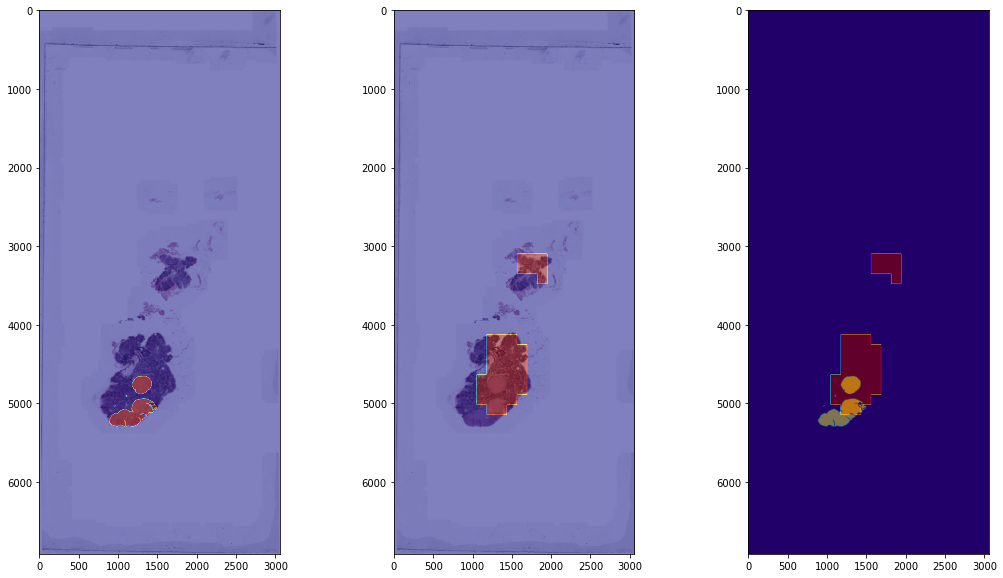

10 19 28 5
Accuracy: 0.46774193548387094
Precision: 0.2631578947368421
Recall: 0.6666666666666666


In [9]:
multi_my_model = models.load_model('multi_simple_model.h5')
test1 = evaluate(test_slide[0], test_mask[0], multi_my_model, 0.5, multi=True)
test1.predict()

Total patches used to test: 225


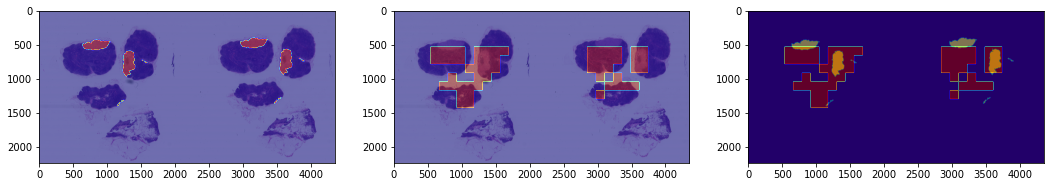

23 42 32 4
Accuracy: 0.6435643564356436
Precision: 0.41818181818181815
Recall: 0.8518518518518519


In [10]:
test2 = evaluate(test_slide[1], test_mask[1], multi_my_model, 0.5, multi=True)
test2.predict()

Total patches used to test: 126


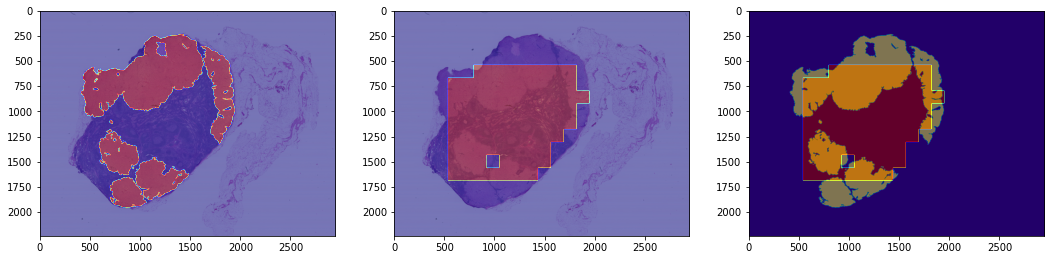

56 2 24 11
Accuracy: 0.6236559139784946
Precision: 0.7
Recall: 0.835820895522388


In [11]:
test3 = evaluate(test_slide[2], test_mask[2], multi_my_model, 0.5, multi=True)
test3.predict()

## Result

By comparing the heatmaps and evaluation metrics, we find that Multi-Scale Simple Model is better since Single-Scale Inception V3 model tend to classify all the input as one class.

# Further Work

1. For the reason why multi-scale input cannot improve inceptionV3 model, we need to dig more into this problem.

> I assume we may need to make some twists on the model, like if the prediction on the Level 5 image is positive, we include level 6 and 7 images as second reference or try a different image model like VGG..

2. For the reason why the model works less satisfying on slide with less cancer tissues, we also need to fix this problem so we can detect the speading of cancer at the early stage.

> I assume we may need to use images with higher resolution, like image at level 3 or 4 to get a better result or further fine our training data or model to detect minor difference of patches.



